# Transit Least Squares (TLS) Tutorial
In this tutorial, we will demonstrate the usage of the *TLS* algorithm for transit detection, which is more sensitive than the Box Least Squares (BLS) method. The transit periodogram computes the power spectrum of the transit fit, maximized over transit depth, duration, and phase, for a list of periods. Peaks in the periodogram generally indicate transiting planets or other unmodeled noise.

To demonstrate the code, we start by downloading the K2 light curve for K2-3: A system with [3 known transiting planets](http://iopscience.iop.org/article/10.1088/0004-637X/804/1/10/meta). This tutorial is inspired by Dan Foreman-Mackey's excellent [BLS tutorial](https://gist.github.com/dfm/96e30d891c0d351daae9aaaef56d3e78).

In [1]:
import numpy
import scipy
import everest
from astropy.stats import sigma_clip
import matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger('matplotlib')
logger.setLevel(logging.CRITICAL)

/home/michael/.local/lib/python3.6/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa




We download the data using the [Everest](https://github.com/rodluger/everest) package and apply a sliding median filter (blue line) to divide out the stellar and instrumental variability. We also clip positive 3-sigma outliers, but leave negative outliers untouched, as these might be part of a transit. We remove long-term trends with a running-window median filter:

INFO  [everest.user.DownloadFile()]: Found cached file.
INFO  [everest.user.load_fits()]: Loading FITS file for 201367065.


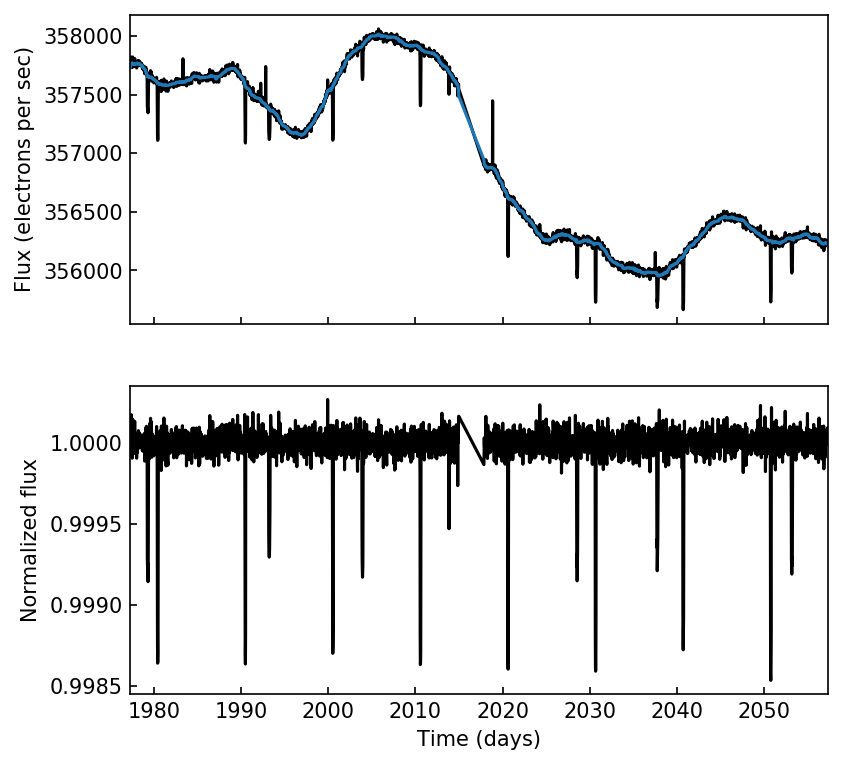

In [2]:
from matplotlib import rcParams; rcParams["figure.dpi"] = 150
EPIC_id = 201367065        
star = everest.Everest(EPIC_id)
t = numpy.delete(star.time, star.badmask)
y = numpy.delete(star.fcor, star.badmask)
t = numpy.array(t[~numpy.isnan(y)], dtype='float32')
y = numpy.array(y[~numpy.isnan(y)], dtype='float32')

trend = scipy.signal.medfilt(y, 25)
y_filt = y /trend
y_filt = sigma_clip(y_filt, sigma_upper=2, sigma_lower=float('inf'))

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(6, 6))
ax = axes[0]
ax.plot(t, y, "k")
ax.plot(t, trend)
ax.set_ylabel("Flux (electrons per sec)")
ax = axes[1]
ax.plot(t, y_filt, "k")
ax.set_xlim(t.min(), t.max())
ax.set_xlabel("Time (days)")
ax.set_ylabel("Normalized flux");

This is a curve which looks suitable for a transit search. The regularly spaced signals look promising. Before we start, we pull priors on limb darkening, stellar radius, and stellar mass. These are used to constraint the period grid and the transit duration grid.

In [3]:
from TransitLeastSquares import TransitLeastSquares, catalog_info
ab, mass, mass_min, mass_max, radius, radius_min, radius_max = catalog_info(EPIC_id)
print('EPIC', EPIC_id)
print('Stellar radius', radius, 'R*. Uncertainties: +', radius_max, '-', radius_min)
print('Stellar mass', mass, 'M*. Uncertainties: +', mass_max, '-', mass_min)
print('Quadratic limb darkening parameters (a, b)=', ab)

EPIC 201367065
Stellar radius 0.371 R*. Uncertainties: + 0.043 - 0.057
Stellar mass 0.414 M*. Uncertainties: + 0.053 - 0.063
Quadratic limb darkening parameters (a, b)= (0.3364, 0.3263)


We set our range of plausible mass and radius values to +-3 sigma of the given uncertainties. We restrict the minimum transit depth to 50 ppm, as we can already spot a transit signal much deeper than that. We set a fine grid for the oversampling and transit duration.

This command runs the actual search, which takes X min on my Intel Core-i7 7700k (4 cores, 8 threads at 4.5 GHz). Note the nice progress bar.

In [4]:
model = TransitLeastSquares(t, y_filt)
results = model.power(
    transit_depth_min=50*10**-6,
    R_star=radius,
    M_star=mass,
    R_star_min=radius - 3*radius_min,
    R_star_max=radius + 3*radius_max,
    M_star_min=mass - 3*mass_min,
    M_star_max=mass + 3*mass_max,
    oversampling_factor=5,
    duration_grid_step=1.02,
    u=ab)

Creating model cache for 213  durations
Searching 3632 data points, 44249 periods from 0.211 to 40.036 days, using all 8 CPU threads


100%|██████████| 44249/44249 periods | 07:54<00:00
  9%|▉         | 336/3632 [00:00<00:01, 1670.77it/s]

Searching for best T0 for period 10.05390


100%|██████████| 3632/3632 [00:02<00:00, 1678.77it/s]


After the search, we plot the power spectrum and the integer (sub)harmonics:

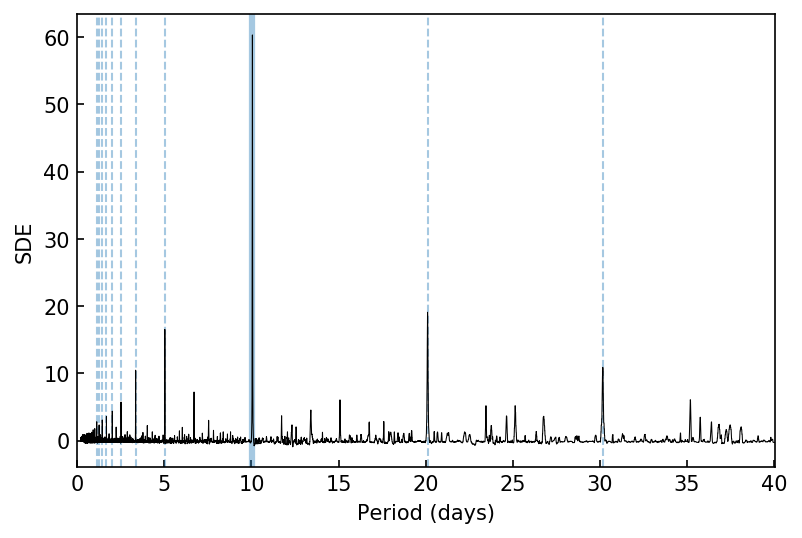

In [5]:
plt.figure()
ax = plt.gca()
ax.axvline(results.period, alpha=0.4, lw=3)
plt.xlim(numpy.min(results.periods), numpy.max(results.periods))
for n in range(2, 10):
    ax.axvline(n*results.period, alpha=0.4, lw=1, linestyle="dashed")
    ax.axvline(results.period / n, alpha=0.4, lw=1, linestyle="dashed")
plt.ylabel(r'SDE')
plt.xlabel('Period (days)')
plt.plot(results.periods, results.power, color='black', lw=0.5)
plt.xlim(0, max(results.periods));

There is a major peak at a period of ~10 days. Let's inspect the statistics:

In [6]:
print('Period', format(results.period, '.5f'), 'd')
print(len(results.transit_times), 'transit times in time series:', \
        ['{0:0.5f}'.format(i) for i in results.transit_times])
print('Transit depth', format(results.depth, '.5f'))
print('Transit duration (days)', format(results.duration, '.5f'))

Period 10.05390 d
8 transit times in time series: ['1980.42177', '1990.47567', '2000.52957', '2010.58347', '2020.63737', '2030.69127', '2040.74517', '2050.79907']
Transit depth 0.99861
Transit duration (days) 0.09945


To get an impression of what this signal looks like, we can create a phase-folded plot:

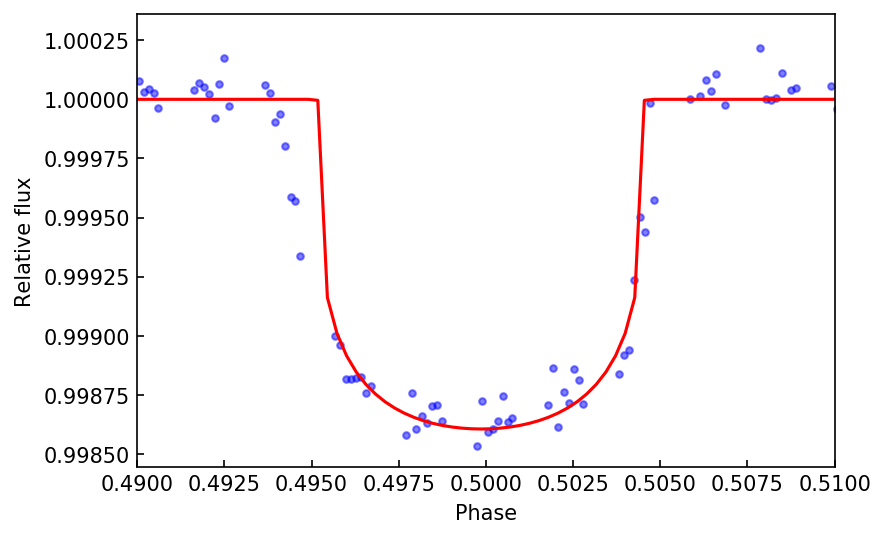

In [7]:
plt.figure()
plt.plot(
    results.model_folded_phase,
    results.model_folded_model,
    color='red')
plt.scatter(
    results.folded_phase,
    results.folded_y,
    color='blue',
    s=10,
    alpha=0.5,
    zorder=2)
plt.xlim(0.49, 0.51)
plt.xlabel('Phase')
plt.ylabel('Relative flux');

There are some high points during the ingress phase, which we attribute to outliers in the data. Other than that, the signal has a limb-darkened transit shape. 

The next plot shows the full light curve, together with the best model (in red). The in-transit data points are also printed in red.

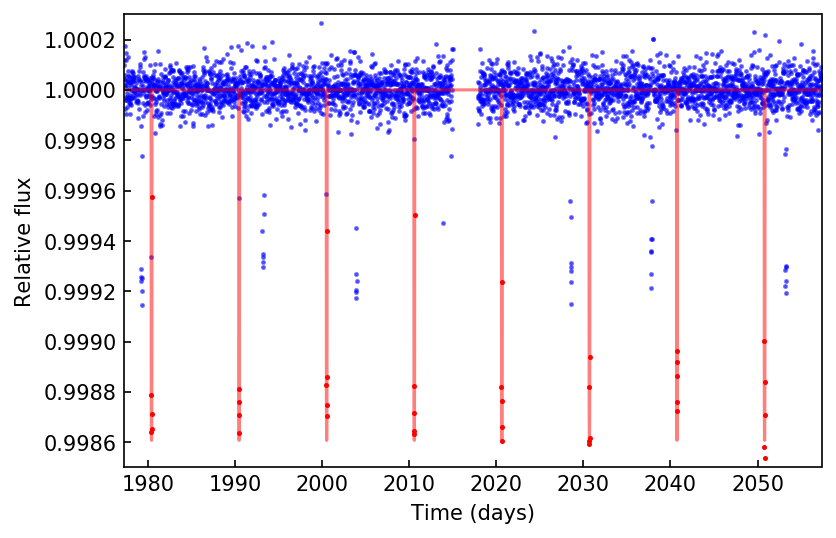

In [11]:
from TransitLeastSquares import transit_mask
plt.figure()
in_transit = transit_mask(
    t,
    results.period,
    results.duration,
    results.T0)
plt.scatter(
    t[in_transit],
    y_filt[in_transit],
    color='red',
    s=2,
    zorder=0)
plt.scatter(
    t[~in_transit],
    y_filt[~in_transit],
    color='blue',
    alpha=0.5,
    s=2,
    zorder=0)
plt.plot(
    results.model_lightcurve_time,
    results.model_lightcurve_model, alpha=0.5, color='red', zorder=1)
plt.xlim(min(t), max(t))
plt.ylim(0.9985, 1.0003)
plt.xlabel('Time (days)')
plt.ylabel('Relative flux');

This looks pretty much like a planet! We have now reached the end of this tutorial. But there is more: This system contains (at least) two more planets! You can head to the tutorial section to learn more about TLS, or head to [part 2 of this tutorial](www.), where we hunt down the other planets using the feature ``transit_mask`` in TLS.